In [1]:
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

import numpy as np

import sklearn
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 700) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import statsmodels
print("statsmodels version: ", statsmodels.__version__)
print("pandas version: ", pd.__version__)

statsmodels version:  0.14.4
pandas version:  2.2.3


In [3]:
# setting the working directory - you need to change this to your own directory
#import os
os.chdir('/home/jovyan/work/CUSP_data_dive/Data')
print(os.getcwd())

/home/jovyan/work/CUSP_data_dive/Data


## 1. Load Data
- Load the data from the csv file

In [4]:
# reading in the regression data that we prepared previously
#import pandas as pd 

tree_reg = pd.read_csv('regression_tree_health.csv', encoding="utf-8")
print(f"Data frame 1 is {tree_reg.shape[0]:,} x {tree_reg.shape[1]}")

Data frame 1 is 4,986 x 11


In [5]:
# sorting our columns
cols= ['treecanopy', 'BHRatio', 'MHI_2022', 'hlthnorm', 'incnorm', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth']

In [6]:
tree_corr_df = tree_reg[cols]

## 2. Correlation Matrix
Do a correlation matrix plot

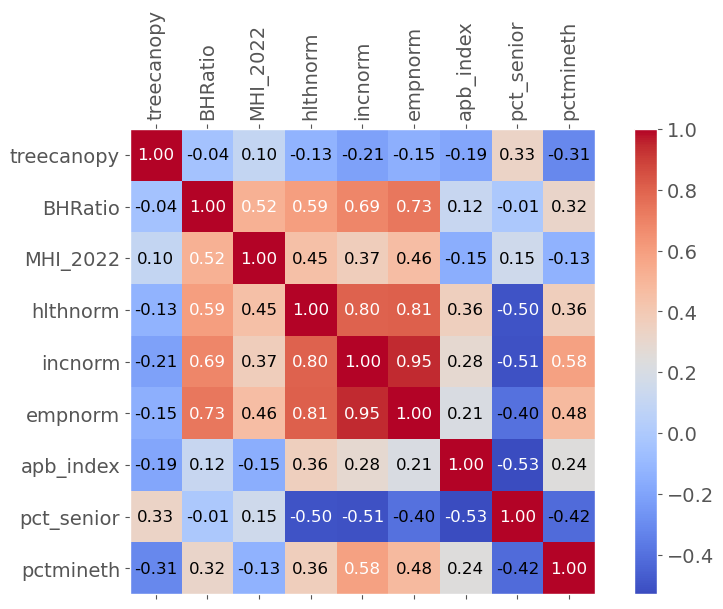

In [7]:
#import numpy as np
#import matplotlib.pyplot as plt

df = tree_corr_df
plt.rcParams["axes.grid"] = False

f = plt.figure(figsize=(10, 6))
corr_matrix = df.corr()  # Compute the correlation matrix

# Create the matrix plot
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm')  # Use a diverging colormap
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)

# Add colorbar
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Overlay correlation coefficients
for (i, j), val in np.ndenumerate(corr_matrix.values):
    plt.text(
        j, i, 
        f"{val:.2f}",  # Format as 2 decimal places
        ha='center', va='center',
        color="black" if abs(val) < 0.5 else "white",  # Text color based on background
        fontsize=12
    )

# Add a title
#plt.title('Pearson Correlation Matrix with Coefficients', fontsize=16, pad=20)

plt.show()

## 3. Define VIF Function tp deal with Multicollinearity

In [8]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [10]:
vif_cols = ['treecanopy', 'incnorm', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth']
vif_df = tree_reg[vif_cols]

In [11]:
# use VIF to remove multicollinearity
# we will first drop the y variables
df_predictors_selected_VIF = drop_column_using_vif_(vif_df)
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: incnorm
The columns remaining after VIF selection are:
Index(['treecanopy', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth'], dtype='object')


## 4. OLS Regression analysis

We will do three regressions with each of the three dependent variables: `BHRatio`, `MHI_2022`, `hlthnorm`.

### 4.1 Regression with `BHRatio` as dependent variable

In [12]:
model_GH = sm.OLS(endog=tree_reg[['BHRatio']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_GH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BHRatio   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     1882.
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:07:56   Log-Likelihood:                 16123.
No. Observations:                4986   AIC:                        -3.223e+04
Df Residuals:                    4980   BIC:                        -3.220e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0159      0.001    -11.868      0.000      -0.019      -0.013
treecanopy    -0.0035      0.002     -2.129      0.033      -0.007      -0.000
empnorm        0.0533      0.001     86.270      0.000       0.052       0.055
apb_index      0.0254      0.002     16.061      0.000       0.022       0.029
pct_senior     0.1321      0.003     40.359      0.000       0.126       0.139
pctmineth      0.0048      0.001      5.521      0.000       0.003       0.007
==============================================================================
Omnibus:                      366.715   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              862.258
Skew:                           0.453   Prob(JB):                    5.79e-188
Kurtosis:                       4.825   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.2 Regression with `hlthnorm` as dependent variable

In [20]:
model_IMDH = sm.OLS(endog=tree_reg[['hlthnorm']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_IMDH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               hlthnorm   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     2434.
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:21:50   Log-Likelihood:                 3157.9
No. Observations:                4986   AIC:                            -6304.
Df Residuals:                    4980   BIC:                            -6265.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.018     -0.506      0.613      -0.045       0.026
treecanopy     0.1100      0.022      4.905      0.000       0.066       0.154
empnorm        0.7014      0.008     84.240      0.000       0.685       0.718
apb_index      0.3091      0.021     14.500      0.000       0.267       0.351
pct_senior    -0.8057      0.044    -18.275      0.000      -0.892      -0.719
pctmineth     -0.1214      0.012    -10.296      0.000      -0.144      -0.098
==============================================================================
Omnibus:                        6.796   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.479
Skew:                           0.038   Prob(JB):                       0.0238
Kurtosis:                       3.174   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.3 Regression with `MHI_2022` as dependent variable

In [22]:
# create a new data frame for MHI_reg, and remove the rows with NAN values in `MHI_2022`
MHI_reg = tree_reg[['MHI_2022', 'treecanopy', 'incnorm', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth']]
MHI_reg = MHI_reg.dropna(subset=['MHI_2022'])
print(f"Data frame is {MHI_reg.shape[0]:,} x {MHI_reg.shape[1]}")

Data frame is 4,651 x 7


In [23]:
MHI_vif_cols = ['treecanopy', 'incnorm', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth']
MHI_vif_df = MHI_reg[MHI_vif_cols]

In [24]:
# use VIF to remove multicollinearity
# we will first drop the y variables
df_predictors_selected_VIF = drop_column_using_vif_(MHI_vif_df)
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: incnorm
The columns remaining after VIF selection are:
Index(['treecanopy', 'empnorm', 'apb_index', 'pct_senior', 'pctmineth'], dtype='object')


In [25]:
model_MH = sm.OLS(endog=MHI_reg[['MHI_2022']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_MH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MHI_2022   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     820.9
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:27:44   Log-Likelihood:                -2248.5
No. Observations:                4651   AIC:                             4509.
Df Residuals:                    4645   BIC:                             4548.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6961      0.058    -11.976      0.000      -0.810      -0.582
treecanopy     0.0365      0.070      0.523      0.601      -0.100       0.173
empnorm        1.6318      0.027     61.475      0.000       1.580       1.684
apb_index     -0.4050      0.068     -5.936      0.000      -0.539      -0.271
pct_senior     3.0089      0.144     20.829      0.000       2.726       3.292
pctmineth     -1.0697      0.037    -28.880      0.000      -1.142      -0.997
==============================================================================
Omnibus:                     1006.171   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4817.689
Skew:                           0.963   Prob(JB):                         0.00
Kurtosis:                       7.599   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5. Assumption Testing

We will plot residual plots to check our assumptions

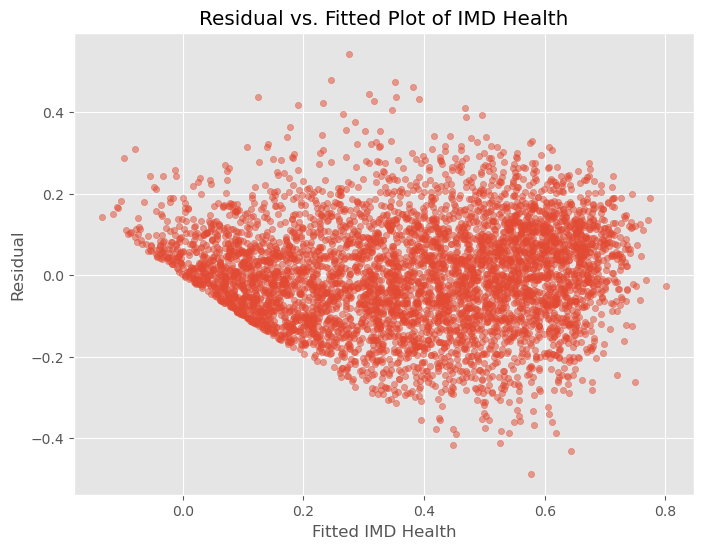

In [26]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model_IMDH.fittedvalues, model_IMDH.resid, alpha = 0.5, s=20)
# plt.scatter(model_fire_rates.fittedvalues, model_fire_rates.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted IMD Health')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of IMD Health')
# Adding grid lines
plt.grid(True)
plt.show()

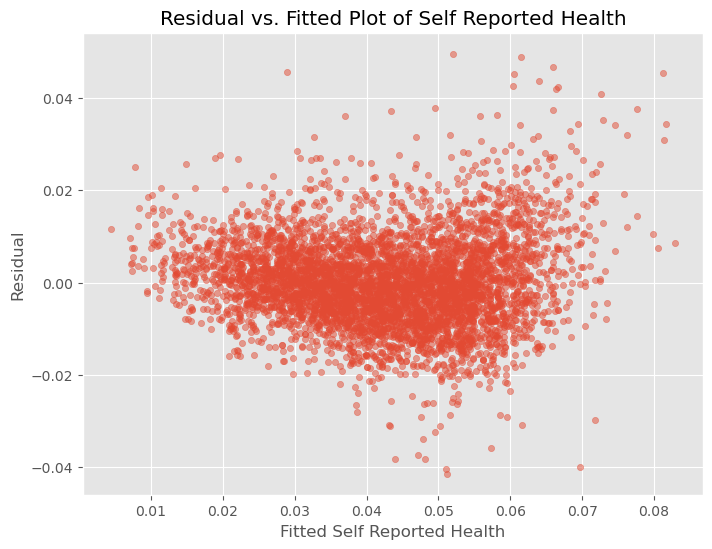

In [27]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model_GH.fittedvalues, model_GH.resid, alpha = 0.5, s=20)
# plt.scatter(model_fire_rates.fittedvalues, model_fire_rates.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted Self Reported Health')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Self Reported Health')
# Adding grid lines
plt.grid(True)
plt.show()

## 6. Visualisation

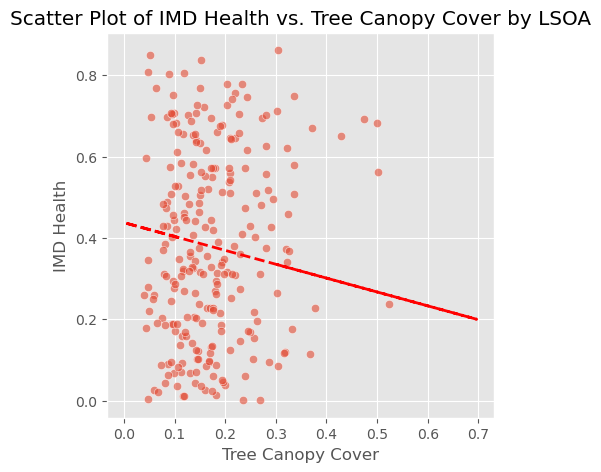

In [32]:
# scatter plot of tree canopy vs. IMD Health

#import numpy as np

# Plotting the scatter plot with a line of best fit
plt.figure(figsize=(5, 5))
plt.scatter(tree_reg['treecanopy'].sample(250), tree_reg['hlthnorm'].sample(250), alpha=0.6, edgecolors='w', linewidth=0.5)

# Calculate the line of best fit
x = tree_reg['treecanopy']
y = tree_reg['hlthnorm']
coeffs = np.polyfit(x, y, 1)  # Linear regression (degree 1)
line_of_best_fit = np.poly1d(coeffs)

# Add the line of best fit to the plot
plt.plot(x, line_of_best_fit(x), color='red', linestyle='--', linewidth=2, label='Best Fit Line')

plt.title('Scatter Plot of IMD Health vs. Tree Canopy Cover by LSOA')
plt.xlabel('Tree Canopy Cover')
plt.ylabel('IMD Health')
#plt.legend()
plt.grid(True)
plt.show()